In [9]:
import cv2
import numpy as np

In [29]:
import kagglehub
import os
import shutil
download = False
if download:
    # Download latest version
    path = kagglehub.dataset_download("ahemateja19bec1025/traffic-sign-dataset-classification")

    print("Path to dataset files:", path)

    # Move files from path to ../../data/
    destination = "../data/"
    if not os.path.exists(destination):
        os.makedirs(destination)

    for filename in os.listdir(path):
        shutil.move(os.path.join(path, filename), os.path.join(destination, filename))
    shutil.rmtree(path)
    ## código usado por si fuera necesario renombrar carpetas 
    import pandas as pd
    import shutil
    import os
    num_to_label = pd.read_csv("../data/labels.csv", index_col="ClassId").to_dict()["Name"]
    num_to_label = {str(k): v for k,v in num_to_label.items()}
    num_to_label = {str(k): v.replace('/', '') for k, v in num_to_label.items()}
    print(num_to_label)

    train_data_dir = "../data/traffic_Data/DATA/"
    for dir in os.listdir(train_data_dir):
        if dir in num_to_label.keys():
            dir_path = os.path.join(train_data_dir, dir)
            new_dir_path = os.path.join(train_data_dir, num_to_label[dir])
            print(f"Renaming {dir_path} to {new_dir_path}")
            if os.path.exists(dir_path):
                if os.path.exists(new_dir_path):
                    shutil.move(dir_path, new_dir_path)
                else:
                    os.renames(dir_path, new_dir_path)
            else:
                print(f"Path {dir_path} does not exist")

    test_data_dir = "../data/traffic_Data/TEST/"

    for image in os.listdir(test_data_dir):
        num = image[:3]
        try:
            num = str(int(num))
            label = num_to_label[num]
            dir_path = os.path.join(test_data_dir, label)
            if not os.path.exists(dir_path):
                os.makedirs(dir_path)

            image_path = os.path.join(test_data_dir, image)
            shutil.move(image_path, dir_path)
        except:
            pass

In [12]:
stop_sign_img = cv2.imread('../../data/stop_sign/two_stop_signs.jpg')
# stop_sign_img = cv2.imread('../../data/images/many_signs.jpeg')
stop_sign_img = cv2.resize(stop_sign_img, (500, 500))
stop_sign_img_2 = cv2.imread('../../data/stop_sign/stop_sign_000.png')
stop_sign_img_2 = cv2.resize(stop_sign_img_2, (500, 500))
turn_right = cv2.imread('../../data/stop_sign/turn_right.jpg')
turn_right = cv2.resize(turn_right, (500, 500))
frames = [stop_sign_img]

In [13]:
stop_sign_reference = cv2.imread('../../data/reference_signs/stop_sign.jpg')
stop_sign_reference.shape

(500, 500, 3)

In [14]:
import cv2 as cv
def show_img(window_name, img, adjust=False):
    """3 arguments: window name, source images, boolean to adjust to screen size"""
    if adjust:
        cv.namedWindow(window_name, cv.WINDOW_NORMAL)
    else:
        cv.namedWindow(window_name)

    cv.imshow(window_name, img)
    cv.waitKey(0)
    cv.destroyAllWindows()

In [15]:
#TODO: Use the method to read the video file (slow_traffic_small.avi)
videopath = "../data/slow_traffic_small.mp4"  # Path to the video file
# frames, frame_width, frame_height, frame_rate = read_video(videopath)

#TODO: Create the Kalman filter object
kf = cv2.KalmanFilter(4, 2)
#TODO: Initialize the state of the Kalman filter
kf.measurementMatrix =  np.array([[1,0,0,0],[0,1,0,0]], np.float32) # Measurement matrix np.array of shape (2, 4) and type np.float32
# en la matriz de measuremente indicamos que unicamente estamos midiendo las posiciones x e y
dt = 50
kf.transitionMatrix = np.array([[1,0,dt,0],[0,1,0,dt],[0,0,1,0],[0,0,0,1]], np.float32) # Transition matrix np.array of shape (4, 4) and type np.float32
kf.processNoiseCov = np.array([[1,0,0,0],[0,1,0,0],[0,0,1,0],[0,0,0,1]], np.float32) *0.03 # Process noise covariance np.array of shape (4, 4) and type np.float32

measurement = np.array((2, 1), np.float32)
prediction = np.zeros((2, 1), np.float32)

#TODO: Show the frames to select the initial position of the object
x,y,(w,h) = 0,0,stop_sign_reference.shape[:2]
track_window = (x, y, w, h)
#TODO: Compute the center of the object
cx = x + w // 2
cy = y + h // 2
#TODO: Initialize the state of the Kalman filter
kf.statePost = np.array([[cx], [cy], [0], [0]], np.float32)

# Initialize the covariance matrix
kf.errorCovPost = np.eye(4, dtype=np.float32)

#Predict the position of the object
prediction = kf.predict()
print(prediction)

#TODO: Update the measurement and correct the Kalman filter
measurement = np.array([[cx], [cy]], np.float32) #en los none introducimos las coordenadas x e y medidas
kf.correct(measurement)

#TODO: Crop the object 
crop = stop_sign_reference[y:y+h, x:x+w].copy() 
#TODO: Convert the cropped object to HSV
hsv_crop = cv2.cvtColor(crop, cv2.COLOR_BGR2HSV)
#TODO: Compute the histogram of the cropped object (Reminder: Use only the Hue channel (0-180))
mask=cv2.inRange(hsv_crop,(0,60,32), (180,255,255))

crop_hist = cv2.calcHist([hsv_crop], [0], mask=mask, histSize=[15], ranges=[0, 180])
cv2.normalize(crop_hist, crop_hist, 0, 255, cv2.NORM_MINMAX)

print(f'Initial position selected: {x}, {y}')
stop_sign_img_copy = stop_sign_img.copy()
cv2.rectangle(stop_sign_img_copy, (x, y), (x+w, y+h), (255, 0, 0), 2)
cv2.imshow("r", stop_sign_img_copy)
cv2.waitKey(0)
cv2.destroyAllWindows()

[[250.]
 [250.]
 [  0.]
 [  0.]]
Initial position selected: 0, 0


In [16]:
# crop_hist

In [17]:
term_crit = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 30, 1)
i=0
# x, y, w, h = 300, 200, 200, 200 # simply hardcoded the values
# track_window = (x, y, w, h)
frames = [stop_sign_img] * 100
for frame in frames[i:]:
    #TODO: Copy the frame 
    input_frame = frame.copy()
    #TODO: Convert the frame to HSV
    img_hsv = cv2.cvtColor(input_frame, cv2.COLOR_BGR2HSV)
    
    # Compute the back projection of the histogram
    img_bproject = cv2.calcBackProject([img_hsv], [0], crop_hist, [0, 180], 1)
    cv2.imshow('Backprojection', img_bproject)
    # cv2.waitKey(0)
    
    # Apply the mean shift algorithm to the back projection
    # print(track_window)
    # ret, track_window = cv2.meanShift(img_bproject, track_window, term_crit)
    ret, track_window = cv2.CamShift(img_bproject, track_window, term_crit)
    x_,y_,w_,h_ = track_window
    #TODO: Compute the center of the object
    c_x = x_ + w_ // 2
    c_y = y_ + h_ // 2
    
    # Predict the position of the object
    prediction = kf.predict()

    #TODO: Update the measurement and correct the Kalman filter
    measurement = np.array([[c_x], [c_y]], np.float32)
    kf.correct(measurement)
    
    # Draw the predicted position
    cv2.circle(input_frame, (int(prediction[0][0]), int(prediction[1][0])), 5, (0, 0, 255), -1)
    cv2.circle(input_frame, (int(c_x), int(c_y)), 5, (0, 255, 0), -1)
    cv2.rectangle(input_frame, (x_, y_), (x_+w_, y_+h_), (255, 0, 0), 2)
    # Show the frame with the predicted position
    cv2.imshow('Frame', input_frame)
    key = cv2.waitKey(0)
    if key == ord('q'):
        break

cv2.destroyAllWindows()

['stop_sign_000.png' 'turn_right.jpg']


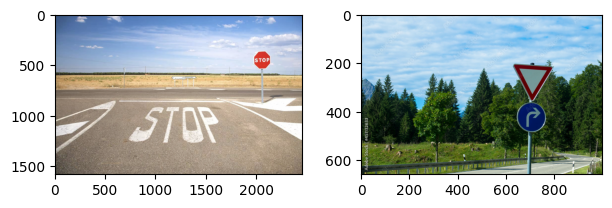

In [18]:
import matplotlib.pyplot as plt
import os
import numpy
import cv2 as cv
import numpy as np

# "images/" is the local file path where all the 4170 images located at
img_dir = "../../data/stop_sign/"
files = np.random.choice(os.listdir(img_dir), size=2, replace=True)
print(files)
plt.figure(figsize=(15, 12))
for i, img_file in enumerate(files):
    img = cv.imread(img_dir + img_file)
    img_rgb = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    plt.subplot(5, 4, i+1)
    plt.imshow(img_rgb)
    
plt.show()

In [19]:
def contrast_enhance(img):
    img_lab = cv.cvtColor(img, cv.COLOR_BGR2Lab)
    L, a, b = cv.split(img_lab)
    L = cv.equalizeHist(L)
    img_lab_merge = cv.merge((L, a, b))
    enhanced_img =  cv.cvtColor(img_lab_merge, cv.COLOR_Lab2BGR)
    result = np.hstack((img, enhanced_img))
    cv2.imshow('Result', result)
    cv2.waitKey(0)
    cv2.destroyAllWindows()
    return enhanced_img

def contrast_enhance2(img):
    lab= cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
    l_channel, a, b = cv2.split(lab)

    # Applying CLAHE to L-channel
    # feel free to try different values for the limit and grid size:
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    cl = clahe.apply(l_channel)

    # merge the CLAHE enhanced L-channel with the a and b channel
    limg = cv2.merge((cl,a,b))

    # Converting image from LAB Color model to BGR color spcae
    enhanced_img = cv2.cvtColor(limg, cv2.COLOR_LAB2BGR)

    # Stacking the original image with the enhanced image
    result = np.hstack((img, enhanced_img))
    cv2.imshow('Result', result)
    cv2.waitKey(0)
    cv2.destroyAllWindows()
    return enhanced_img
contrast_enhance(stop_sign_img)
contrast_enhance2(stop_sign_img)
...

Ellipsis

In [20]:


# canny edge detection
def auto_canny(img, method, sigma=0.33):
    """
    Args:
    img: grayscale image
    method: Otsu, triangle, and median
    sigma: 0.33 (default)
    2 outputs:
    edge_detection output, the high threshold for Hough Transform"""
    if method=="median":
        Th = np.median(img)
        
    elif method=="triangle":
        Th, _ = cv.threshold(img, 0, 255, cv.THRESH_TRIANGLE)
        
    elif method=="otsu":
        Th, _ = cv.threshold(img, 0, 255, cv.THRESH_OTSU)
        
    else:
        raise Exception("method specified not available!")
        
    lowTh = (1-sigma) * Th
    highTh = (1+sigma) * Th
    
    return cv.Canny(img, lowTh, highTh), highTh

In [21]:
def nothing(x):
    pass
def get_hsv_color_ranges(image: np.array):

    # Create a window
    cv2.namedWindow("image")

    # Create trackbars for color change
    cv2.createTrackbar("HMin", "image", 0, 255, nothing)
    cv2.createTrackbar("SMin", "image", 0, 255, nothing)
    cv2.createTrackbar("VMin", "image", 0, 255, nothing)
    cv2.createTrackbar("HMax", "image", 0, 255, nothing)
    cv2.createTrackbar("SMax", "image", 0, 255, nothing)
    cv2.createTrackbar("VMax", "image", 0, 255, nothing)

    # Set default value for MAX HSV trackbars.
    cv2.setTrackbarPos("HMax", "image", 255)
    cv2.setTrackbarPos("SMax", "image", 255)
    cv2.setTrackbarPos("VMax", "image", 255)

    # Initialize to check if HSV min/max value changes
    hMin = sMin = vMin = hMax = sMax = vMax = 0
    phMin = psMin = pvMin = phMax = psMax = pvMax = 0

    output = image
    wait_time = 33

    while 1:

        # get current positions of all trackbars
        hMin = cv2.getTrackbarPos("HMin", "image")
        sMin = cv2.getTrackbarPos("SMin", "image")
        vMin = cv2.getTrackbarPos("VMin", "image")

        hMax = cv2.getTrackbarPos("HMax", "image")
        sMax = cv2.getTrackbarPos("SMax", "image")
        vMax = cv2.getTrackbarPos("VMax", "image")

        # Set minimum and max HSV values to display
        lower = np.array([hMin, sMin, vMin])
        upper = np.array([hMax, sMax, vMax])

        # Create HSV Image and threshold into a range.
        hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
        mask = cv2.inRange(hsv, lower, upper)
        output = cv2.bitwise_and(image, image, mask=mask)

        # Print if there is a change in HSV value
        if (
            (phMin != hMin)
            | (psMin != sMin)
            | (pvMin != vMin)
            | (phMax != hMax)
            | (psMax != sMax)
            | (pvMax != vMax)
        ):
            # print(
            #     "(hMin = %d , sMin = %d, vMin = %d), (hMax = %d , sMax = %d, vMax = %d)"
            #     % (hMin, sMin, vMin, hMax, sMax, vMax)
            # )
            phMin = hMin
            psMin = sMin
            pvMin = vMin
            phMax = hMax
            psMax = sMax
            pvMax = vMax

        # Display output image
        cv2.imshow("image", output)
        cv2.resizeWindow("image", 500, 300)

        # Wait longer to prevent freeze for videos.
        if cv2.waitKey(wait_time) & 0xFF == ord("q"):
            break

    cv2.destroyAllWindows()


In [22]:
get_hsv_color_ranges(contrast_enhance(cv2.resize(turn_right, (200,200))))
get_hsv_color_ranges(contrast_enhance(stop_sign_img_2))

In [23]:
# Color based segmentation
# Color based segmentation (red, blue, yellow, black)
# Red color
lower_red1 = (0, 40, 50)
upper_red1 = (191, 250, 126)
lower_red1 = (0, 50, 50)
upper_red1 = (10, 255, 255)
lower_red2 = (170, 50, 50)
upper_red2 = (180, 255, 255)

# Blue color 
lower_blue = (100, 40, 50)
upper_blue = (120, 255, 210)

# Yellow colors
lower_yellow = (20, 40, 50)
upper_yellow = (35, 255, 210)

# black colors
lower_black = (0, 0, 0)
upper_black = (179, 255, 5)

def color_seg(img, kernel_size=None):
    """Args:
    img: image in bgr
    kernel_size: None (default:(3, 3))"""
    hsv_img = cv.cvtColor(img, cv.COLOR_BGR2HSV)
    
    mask_red1 = cv.inRange(hsv_img, lower_red1, upper_red1)
    mask_red2 = cv.inRange(hsv_img, lower_red2, upper_red2)
    mask_blue = cv.inRange(hsv_img, lower_blue, upper_blue)
    mask_yellow = cv.inRange(hsv_img, lower_yellow, upper_yellow)
    mask_black = cv.inRange(hsv_img, lower_black, upper_black)
    
    # mask_combined = mask_red1 | mask_red2 | mask_blue | mask_yellow | mask_black
    mask_combined = mask_red1 | mask_blue | mask_red2 #| mask_yellow | mask_black
    
    if kernel_size is not None:
        kernel = np.ones(kernel_size, np.uint8)
    else:
        kernel = np.ones((3, 3), np.uint8)
        
    # Apertura para limpiar
    mask_combined = cv.morphologyEx(mask_combined, cv.MORPH_OPEN, kernel)
    mask_combined = cv.morphologyEx(mask_combined, cv.MORPH_CLOSE, kernel)
    
    return mask_combined
# mask = color_seg(contrast_enhance(stop_sign_img))
# show_img("mask", mask)
# mask = color_seg(contrast_enhance(stop_sign_img_2))
# show_img("mask", mask)
mask = color_seg(contrast_enhance(turn_right))
show_img("mask", mask)

In [24]:
# rectangle detection (using Douglas-Peuker algorithm)
def cnt_rect(cnts, coef=0.1):
    contour_list = []
    for cnt in cnts:
        peri = cv.arcLength(cnt, True)
        approx = cv.approxPolyDP(cnt, coef*peri, True)
        if len(approx) == 4:
            contour_list.append(cnt)

    if not contour_list:
        return None
    else:
        LC = max(contour_list, key=cv.contourArea)
        return LC
    
# circle detection
hough_circle_parameters = {
    "dp": 1,
    "minDist": 150,
    "param1": 200,    # adaptively change according to image
    "param2": 15,  
    "minRadius": 1,
    "maxRadius": 500
}
def cnt_circle(img, hough_dict):
    """Args:
    img: Grayscale Image after resizing
    cnt: contour
    hough_dict: hough_circle_transform parameters"""
    mask = np.zeros_like(img)
    circles = cv.HoughCircles(img, 
                              cv.HOUGH_GRADIENT, 
                              hough_dict["dp"], 
                              hough_dict["minDist"], 
                              param1=hough_dict["param1"], 
                              param2=hough_dict["param2"],
                              minRadius=hough_dict["minRadius"], 
                              maxRadius=hough_dict["maxRadius"])
    if circles is None:
        return circles
    else:
        # perform LCA
        list_circles = circles[0]
        largest_circles = max(list_circles, key=lambda x: x[2])
        center_x, center_y, r = largest_circles
        cv.circle(mask, (int(center_x), int(center_y)), int(r), 255)
        cnts = cv.findContours(mask, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
        cnt = cnts[0]
        if len(cnts[0])>0:
            return max(cnt, key=cv.contourArea)
        else:
            return cnt[-1]

In [25]:
# combine the results of 2 shape detectors
def integrate_circle_rect(rect_cnt, circle_cnt, cnt):
    if circle_cnt is not None and rect_cnt is not None:
        # compare the area
        if cv.contourArea(circle_cnt) >= cv.contourArea(rect_cnt):
            output = circle_cnt
        else:
            output = rect_cnt

    elif circle_cnt is not None and rect_cnt is None:
        output = circle_cnt

    elif circle_cnt is None and rect_cnt is not None:
        output = rect_cnt

    else:
        if len(cnt)==0:
            return np.array([])
        else:
            output = max(cnt, key=cv.contourArea)

    return output

# combine the results of edge detector + color based segmentation followed by shape detection combined results
def integrate_edge_color(output1, output2):
    if not isinstance(output1, np.ndarray):
        output1 = np.array(output1)
        
    if not isinstance(output2, np.ndarray):
        output2 = np.array(output2)
        
    if len(output1)==0 and len(output2)==0:
        return np.array([])
    
    elif len(output1)==0 and output2.shape[-1]==2:
        return output2
    
    elif len(output2)==0 and output1.shape[-1]==2:
        return output1
    
    else:
        if cv.contourArea(output1[0]) > cv.contourArea(output2[0]):
            return output1
        else:
            return output2

In [26]:
# Calculate the IoU between two bounding boxes
def computeIOU(boxA, boxB):
    x_start = max(boxA[0], boxB[0])
    y_start = max(boxA[1], boxB[1])
    x_end = min(boxA[2], boxB[2])
    y_end = min(boxA[3], boxB[3])
    
    interArea = max(0, x_end - x_start + 1) * max(0, y_end - y_start + 1)
    areaA = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
    areaB = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)
    
    return interArea / (areaA + areaB - interArea)
import cv2 as cv
# from scipy.spatial.distance import euclidean
# import math
import numpy as np



In [27]:
def mser(img):
    # Import packages 
    import cv2
    import numpy as np

    #Create MSER object
    mser_object = cv2.MSER_create(delta = 5, max_variation = 0.4)

    #Your image path i-e receipt path
    # img = cv2.imread('../../data/stop_sign/stop_sign_000.png')
    # img = cv2.imread('../../data/stop_sign/turn_right.jpg')
    # img = cv2.imread('../../data/stop_sign/two_stop_signs.jpg')
    # img = cv2.resize(img, (500,500))

    #Convert to gray scale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    vis = img.copy()

    #detect regions in gray scale image
    regions, _ = mser_object.detectRegions(gray)

    hulls = [cv2.convexHull(p.reshape(-1, 1, 2)) for p in regions]

    cv2.polylines(vis, hulls, 1, (0, 255, 0))

    cv2.imshow('img', vis)

    cv2.waitKey(0)
    cv2.destroyAllWindows()

    mask = np.zeros((img.shape[0], img.shape[1], 1), dtype=np.uint8)

    for contour in hulls:

        cv2.drawContours(mask, [contour], -1, (255, 255, 255), -1)

    #this is used to find only text regions, remaining are ignored
    text_only = cv2.bitwise_and(img, img, mask=mask)

    cv2.imshow("text only", text_only)

    cv2.waitKey(0)
    cv2.destroyAllWindows()
    return text_only

In [31]:
from skimage.exposure import is_low_contrast
from pathlib import Path

img_dir = Path(img_dir)

IOUs = []
i = 0
fixed_width = 500
files_no_det = []
img_iou_zero = []
for file in img_dir.glob("*.*"):
    str_fn = str(file)
    img = cv.imread(str_fn)
    if img is None:
        print("No such file exists")
        break
    img_copy = img.copy()
    i += 1
    filename = str_fn.split("\\")[-1]
    
    # Denoise the image + change to grayscale
    img_denoised = cv.medianBlur(img_copy, 3)
    if is_low_contrast(img_denoised):
        img_denoised = contrast_enhance(img_denoised)
    img_denoised = contrast_enhance(img_denoised)
    # Resize the image
    ratio = fixed_width / img.shape[1]
    img_resized = cv.resize(img_denoised, None, fx=ratio, fy=ratio, interpolation=cv.INTER_AREA)
    img_resized_mser = mser(img_resized)
    # change to grayscale
    gray = cv.cvtColor(img_resized_mser, cv.COLOR_BGR2GRAY)

    #1: Edge detection + shape detection + combine results of shape detector
    edge, canny_th2 = auto_canny(gray, "otsu")
    show_img("canny", edge)
    # Perform shape detectors
    cnts = cv.findContours(edge, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
    cnt_edge = cnts[0]
    cnt = cnts[0]
    rect_edge = cnt_rect(cnt)
    # show_img("contours", cnts)
    hough_circle_parameters["param1"] = canny_th2
    circle_edge = cnt_circle(gray, hough_circle_parameters)

    output1 = integrate_circle_rect(rect_edge, circle_edge, cnt_edge)

    # color segmentation
    color_segmented = color_seg(img_resized_mser)
    show_img("segmented", color_segmented)
    # perform rectangular object detection
    cnts = cv.findContours(color_segmented, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
    cnt = cnts[0]
    rect = cnt_rect(cnt)
    
    # perform circular object detection
    hough_circle_parameters["param1"] = 200
    circle = cnt_circle(color_segmented, hough_circle_parameters)

    output2 = integrate_circle_rect(rect, circle, cnt)
    
    # ground truth bb
    # gt_bb = np.array([annotations.loc[filename].x_start, 
    #                   annotations.loc[filename].y_start,
    #                   annotations.loc[filename].x_end,
    #                   annotations.loc[filename].y_end])
    gt_bb = np.array([0,2,0,2])
    gt_bb = (gt_bb*ratio).astype(int)

    cv.rectangle(img_resized, (gt_bb[0], gt_bb[1]), (gt_bb[2], gt_bb[3]), (255, 0, 0), 2)
    
    # integrate output1 and output2
    final_output = integrate_edge_color(output1, output2)
    if len(final_output) == 0:
        print("no detection!")
        show_img("no detection", img_resized)
        IOUs.append(0)
        files_no_det.append(str_fn)
    else:
        x, y, w, h = cv.boundingRect(final_output)
        cv.rectangle(img_resized, (x, y), (x+w, y+h), (0, 255, 0), 2)

        pred_bb = (x, y, x+w, y+h)

        # IOU = computeIOU(gt_bb, pred_bb)

        # cv.putText(img_resized_mser, f"IOU: {IOU:.3f}", (12, 12), cv.FONT_HERSHEY_SIMPLEX, 0.4, (0, 0, 255))
        # IOUs.append(IOU)
        
        # if IOU==0:
        #     img_iou_zero.append(img_resized_mser)
        
        # if i % 1000 == 0:
        #     show_img("results", img_resized_mser)
        show_img("results", img_resized)